In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import scipy as sp
import os
import pickle
from decimal import Decimal
import h5py
import itertools
from collections import OrderedDict
import imp
from tqdm import tqdm

from scipy.stats import norm

import astropy.constants as C
import astropy.units as u
import astropy as ap

import peters
import bounded_Nd_kde
from IPython.core.debugger import set_trace
from importlib import reload

from matplotlib import gridspec
import matplotlib
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator

cp = sns.color_palette("colorblind", 6)

plt.style.use("/Users/michaelzevin/.MATPLOTLIB_RCPARAMS.sty")

In [2]:
alpha_val = '10'
models_path = '/Users/michaelzevin/research/model_selection/model_selection/data/spin_models/models_reduced.hdf5'
sensitivity = 'midhighlatelow_network'
param_dict = {'mchirp':r'$\mathcal{M}_c\ [\mathrm{M}_\odot]$', 'q':r'$q$', 'chieff':r'$\chi_{\rm eff}$', 'z':r'$z$'}
param_lims = {'mchirp':(0,100), 'q':(0,1), 'chieff':(-1,1), 'z':(0,10)}
smdl_dict = {'chi00':r'$\chi_b = 0.0$', 'chi01':r'$\chi_b = 0.1$', 'chi02':r'$\chi_b = 0.2$', 'chi05':r'$\chi_b = 0.5$'}

In [3]:
all_models = []
models = []
def find_submodels(name, obj):
    if isinstance(obj, h5py.Dataset):
        all_models.append(name.rsplit('/', 1)[0])
        
f = h5py.File(models_path, 'r')
f.visititems(find_submodels)
# get all unique models
all_models = sorted(list(set(all_models)))
f.close()

# use only models with given alpha value
for model in all_models:
    if 'alpha' in model:
        if 'alpha'+alpha_val in model:
            models.append(model)
    else:
        models.append(model)
        

In [4]:
channels = sorted(set([x.split('/')[0] for x in models]))
smdls = sorted(set([x.split('/')[1] for x in models]))

### Test bounded, weighted KDEs

In [5]:
reload(bounded_Nd_kde)

mdl = 'CE/chi00/alpha10'
df = pd.read_hdf(models_path, key=mdl)
Nsamp = 100000
bw = 0.01
normalized = False
detectable = False
df = df.sample(Nsamp) if len(df)>Nsamp else df

df['cosmo_weight'] = df['weight']/np.sum(df['weight'])

df['combined_weight'] = (df['weight']/np.sum(df['weight'])) * (df['pdet_'+sensitivity]/np.sum(df['pdet_'+sensitivity]))
df['combined_weight'] /= np.sum(df['combined_weight'])

if normalized == True:
    # Normalize the samples
    params = ['mchirp','q','chieff','z']
    for param in params:
        df[param] = (df[param]-param_lims[param][0])/(param_lims[param][1]-param_lims[param][0])
        
reload(bounded_Nd_kde)

<module 'bounded_Nd_kde' from '/Users/michaelzevin/research/utilities/bounded_Nd_kde.py'>

#### 4D

In [7]:
params=['mchirp','q','chieff','z']
eval_pts = np.asarray([np.linspace(*param_lims[params[0]], 101), np.linspace(*param_lims[params[1]], 101), \
                       np.linspace(*param_lims[params[2]], 101), np.linspace(*param_lims[params[3]], 101)])

X = np.atleast_2d([df[params[0]],df[params[1]],df[params[2]],df[params[3]]])
Bounds = np.atleast_2d([param_lims[params[0]],param_lims[params[1]],param_lims[params[2]],param_lims[params[3]]])

if normalized == True:
    Bounds = np.atleast_2d([(0,1),(0,1),(0,1),(0,1)])
    eval_pts = np.asarray([np.linspace(0,1, 101), np.linspace(0,1, 101), np.linspace(0,1, 101), np.linspace(0,1, 101)])


kde_unweighted = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=bw)
kde_cosmo_weighted = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=bw, weights=np.asarray(df['cosmo_weight']))
kde_pdet_weighted = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=bw, weights=np.asarray(df['combined_weight']))

kde_eval = kde_unweighted(eval_pts)
kde_eval_cosmo_weighted = kde_cosmo_weighted(eval_pts)
kde_eval_pdet_weighted = kde_pdet_weighted(eval_pts)

resamp_unweighted = kde_unweighted.bounded_resample(Nsamp)
resamp_cosmo_weighted = kde_cosmo_weighted.bounded_resample(Nsamp)
resamp_pdet_weighted = kde_pdet_weighted.bounded_resample(Nsamp)

In [8]:
print('Nrefl: {}'.format(kde_unweighted._refl_norm_factor))

Nrefl: 25


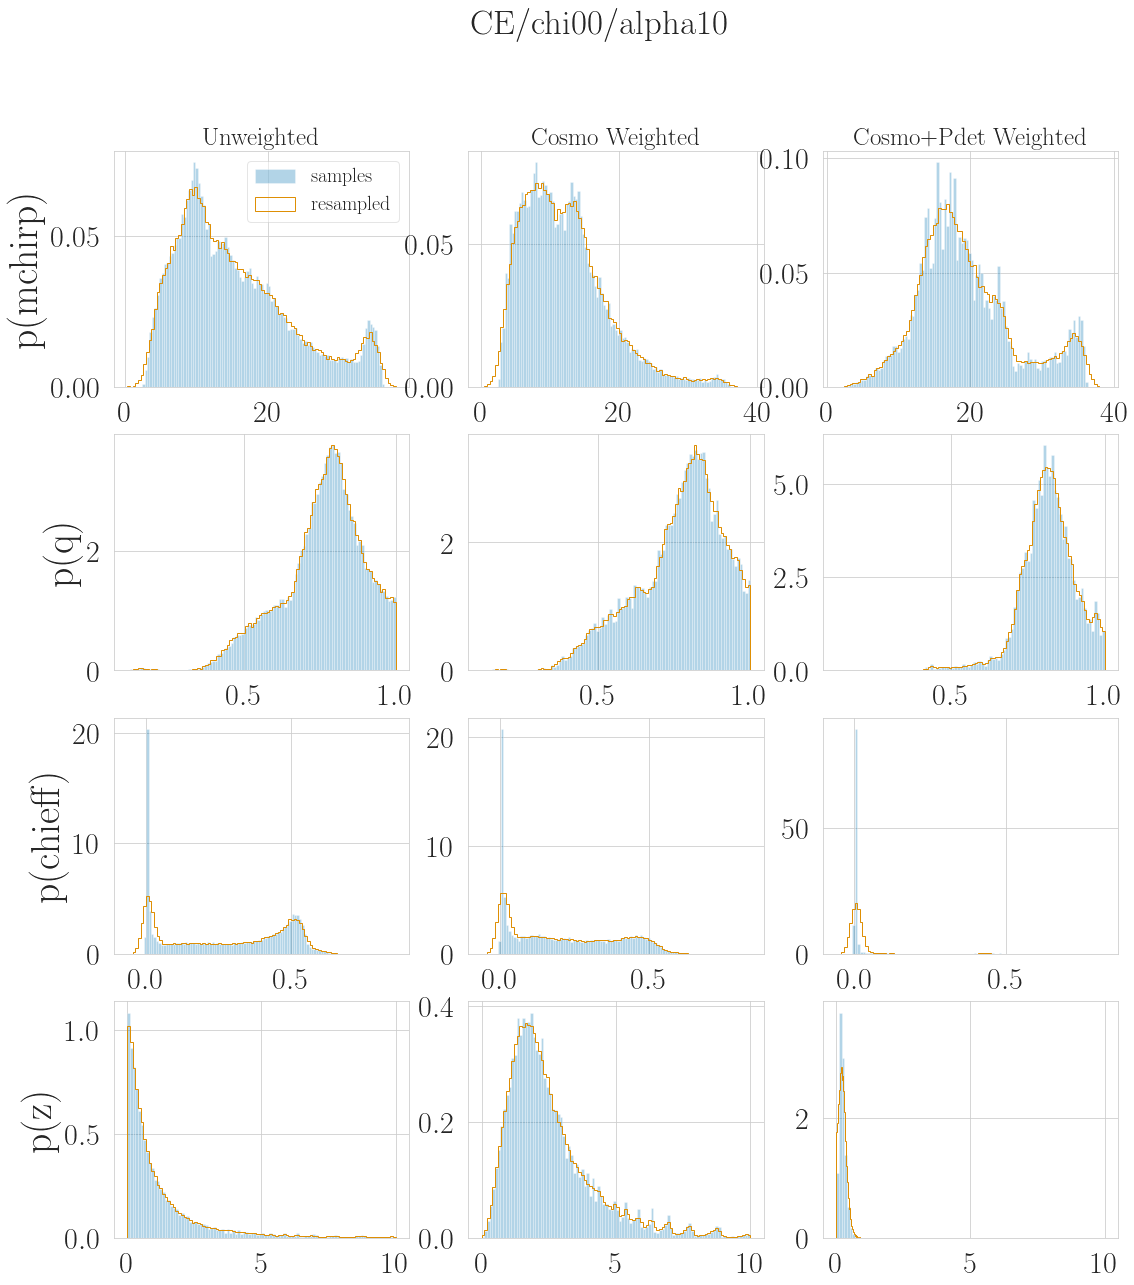

In [9]:
# check 1D distributions against KDE resample
N=10000

fig, axs = plt.subplots(len(params),3, figsize=(18,5*len(params)))

plt.suptitle(mdl, fontsize=35)

axs[0,0].set_title('Unweighted', fontsize=25)
axs[0,1].set_title('Cosmo Weighted', fontsize=25)
axs[0,2].set_title('Cosmo+Pdet Weighted', fontsize=25)

for idx, param in enumerate(params):
    axs[idx,0].set_ylabel('p({:s})'.format(params[idx]))
    
    if normalized == True:
        h, bins, _ = axs[idx,0].hist(df[param]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=100, density=True, alpha=0.3, color=cp[0], label='samples')
        h, bins, _ = axs[idx,0].hist(resamp_unweighted[idx]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=100, density=True, histtype='step', color=cp[1], label='resampled')
        h, bins, _ = axs[idx,1].hist(df[param]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=100, density=True, weights=np.asarray(df['cosmo_weight']), alpha=0.3, color=cp[0])
        h, bins, _ = axs[idx,1].hist(resamp_cosmo_weighted[idx]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=100, density=True, histtype='step', color=cp[1])
        h, bins, _ = axs[idx,2].hist(df[param]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=100, density=True, weights=np.asarray(df['combined_weight']), alpha=0.3, color=cp[0])
        h, bins, _ = axs[idx,2].hist(resamp_pdet_weighted[idx]*(param_lims[param][1]-param_lims[param][0]) + param_lims[param][0], bins=100, density=True, histtype='step', color=cp[1])
    else:
        h, bins, _ = axs[idx,0].hist(df[param], bins=100, density=True, alpha=0.3, color=cp[0], label='samples')
        h, bins, _ = axs[idx,0].hist(resamp_unweighted[idx], bins=100, density=True, histtype='step', color=cp[1], label='resampled') 
        h, bins, _ = axs[idx,1].hist(df[param], bins=100, density=True, weights=np.asarray(df['cosmo_weight']), alpha=0.3, color=cp[0])
        h, bins, _ = axs[idx,1].hist(resamp_cosmo_weighted[idx], bins=100, density=True, histtype='step', color=cp[1])
        h, bins, _ = axs[idx,2].hist(df[param], bins=100, density=True, weights=np.asarray(df['combined_weight']), alpha=0.3, color=cp[0])
        h, bins, _ = axs[idx,2].hist(resamp_pdet_weighted[idx], bins=100, density=True, histtype='step', color=cp[1])
        
    axs[0,0].legend(prop={'size':20})
